In [1]:
pip install -q ads

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 2.4 MB/s eta 0:00:00


In [7]:
import ads
import pandas as pd

# ==============================
# 1. Configure NASA ADS API key
# ==============================
ads.config.token = ""  # <-- Insert ADS API token here

# ==============================
# 2. Define search queries
# ==============================
queries = [
    'abs:"radio frequency interference" AND abs:"machine learning" AND property:refereed AND collection:astronomy AND year:[2024 TO 2026]',
    'abs:"radio frequency interference" AND abs:"neural network" AND property:refereed AND collection:astronomy AND year:[2024 TO 2026]',
    'abs:"radio frequency interference" AND abs:"deep learning" AND property:refereed AND collection:astronomy AND year:[2024 TO 2026]',
    'abs:"RFI" AND abs:"machine learning" AND property:refereed AND collection:astronomy AND year:[2024 TO 2026]'
]

# ==============================
# 3. Collect data
# ==============================
all_data = []
seen_titles = set()

for query in queries:
    print(f"Processing query: {query[:70]}...")

    papers = list(
        ads.SearchQuery(
            q=query,
            fl=['title', 'author', 'year', 'doi', 'citation_count', 'pub', 'keyword'],
            max_pages=400
        )
    )

    for paper in papers:
        # Title
        title = paper.title[0] if paper.title else ""

        # Skip duplicates (case-insensitive)
        if title.lower() in seen_titles:
            continue
        seen_titles.add(title.lower())

        # Authors
        authors = ", ".join(paper.author) if paper.author else ""

        # Year
        year = int(paper.year) if paper.year else None

        # DOI link
        if paper.doi and len(paper.doi) > 0:
            doi_link = f"https://doi.org/{paper.doi[0]}"
        else:
            doi_link = ""

        # Citation count
        citation_count = paper.citation_count if paper.citation_count else 0

        # Journal
        journal = paper.pub if paper.pub else ""

        # Keywords
        keywords = ", ".join(paper.keyword) if paper.keyword else ""

        all_data.append({
            "Title": title,
            "Author(s)": authors,
            "Year": year,
            "DOI Link": doi_link,
            "Citation Count": citation_count,
            "Journal": journal,
            "Keywords": keywords
        })

# ==============================
# 4. Create DataFrame
# ==============================
df = pd.DataFrame(all_data)

# Remove duplicates again (extra safety)
df = df.drop_duplicates(subset=["Title"], keep="first")

# Sort by Year (desc) then Citation Count (desc)
df = df.sort_values(by=["Year", "Citation Count"], ascending=[False, False])

# ==============================
# 5. Export to Excel
# ==============================
output_filename = "nasa_ads_ML_combined_2024_2026.xlsx"
df.to_excel(output_filename, index=False)

print("\nTotal unique papers found:", len(df))
print(f"Data has been successfully saved to '{output_filename}'.")

Processing query: abs:"radio frequency interference" AND abs:"machine learning" AND prop...
Processing query: abs:"radio frequency interference" AND abs:"neural network" AND proper...
Processing query: abs:"radio frequency interference" AND abs:"deep learning" AND propert...
Processing query: abs:"RFI" AND abs:"machine learning" AND property:refereed AND collect...

Total unique papers found: 36
Data has been successfully saved to 'nasa_ads_ML_combined_2024_2026.xlsx'.


In [8]:
# Number of rows and columns
df.shape

# Quick info on columns and types
df.info()

# Summary stats for numeric columns (Year, Citation Count)
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 36 entries, 0 to 34
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Title           36 non-null     object
 1   Author(s)       36 non-null     object
 2   Year            36 non-null     int64 
 3   DOI Link        36 non-null     object
 4   Citation Count  36 non-null     int64 
 5   Journal         36 non-null     object
 6   Keywords        36 non-null     object
dtypes: int64(2), object(5)
memory usage: 2.2+ KB


,Year,Citation Count
count,36.000000,36.000000
mean,2024.777778,4.222222
std,0.637455,7.329436
min,2024.000000,0.000000
25%,2024.000000,0.000000
50%,2025.000000,2.500000
75%,2025.000000,5.000000
max,2026.000000,42.000000


In [9]:
# Papers per year
df['Year'].value_counts().sort_index(ascending=True)

,count
Year,
2024,12
2025,20
2026,4


In [10]:
# Top 10 journals by number of papers
df['Journal'].value_counts().head(10)

,count
Journal,
The Astronomical Journal,5
Monthly Notices of the Royal Astronomical Society,5
Astronomy and Astrophysics,4
Astronomy and Computing,3
The Astrophysical Journal Supplement Series,3
"Science China Physics, Mechanics, and Astronomy",2
Publications of the Astronomical Society of Australia,2
Communications Physics,1
URSI Radio Science Letters,1


In [11]:
# Basic citation stats
df['Citation Count'].describe()

# Most cited 10 papers
top_cited = df.sort_values('Citation Count', ascending=False).head(10)
top_cited[['Title', 'Year', 'Citation Count', 'Journal']]

,Title,Year,Citation Count,Journal
10,Deeper multi-redshift upper limits on the epoc...,2025,42,Astronomy and Astrophysics
12,First upper limits on the 21-cm signal power s...,2025,16,Monthly Notices of the Royal Astronomical Society
28,A comparison framework for deep learning RFI d...,2024,9,Monthly Notices of the Royal Astronomical Society
20,DRAFTS: A Deep-learning-based Radio Fast Trans...,2025,8,The Astrophysical Journal Supplement Series
4,A Needle in a Cosmic Haystack: A Review of FRB...,2024,7,Universe
11,RFI detection with spiking neural networks,2024,7,Publications of the Astronomical Society of Au...
25,Radio frequency interference detection using e...,2024,6,Monthly Notices of the Royal Astronomical Society
26,Remove First Detect Later: a counter-intuitive...,2024,6,Monthly Notices of the Royal Astronomical Society
16,Spiking neural networks for radio frequency in...,2025,5,Communications Physics
33,Reference-frame-independent quantum key distri...,2025,5,"Science China Physics, Mechanics, and Astronomy"


In [12]:
# How many papers contain each keyword (simple split on comma)
from collections import Counter

all_keywords = []

for kws in df['Keywords'].dropna():
    for k in kws.split(','):
        k = k.strip()
        if k:
            all_keywords.append(k)

keyword_counts = Counter(all_keywords)
keyword_counts.most_common(20)  # top 20 keywords

[('Instrumentation and Methods for Astrophysics', 10),
 ('methods: data analysis', 8),
 ('Astrophysics - Instrumentation and Methods for Astrophysics', 8),
 ('Radio astronomy', 7),
 ('techniques: interferometric', 5),
 ('Astrophysics - High Energy Astrophysical Phenomena', 5),
 ('1338', 4),
 ('Search for extraterrestrial intelligence', 3),
 ('Astronomy data analysis', 3),
 ('2127', 3),
 ('1858', 3),
 ('Machine Learning', 3),
 ('cosmology: observations', 3),
 ('Convolutional neural networks', 3),
 ('1938', 3),
 ('Technosignatures', 3),
 ('Neural and Evolutionary Computing', 3),
 ('techniques: image processing', 3),
 ('Radio frequency interference', 2),
 ('dark ages', 2)]

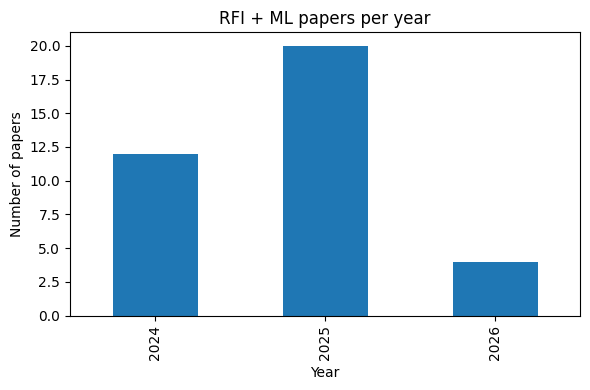

In [13]:
import matplotlib.pyplot as plt

# Bar plot: papers per year
year_counts = df['Year'].value_counts().sort_index()

plt.figure(figsize=(6,4))
year_counts.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Number of papers')
plt.title('RFI + ML papers per year')
plt.tight_layout()
plt.show()

/tmp/ipython-input-1066671999.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


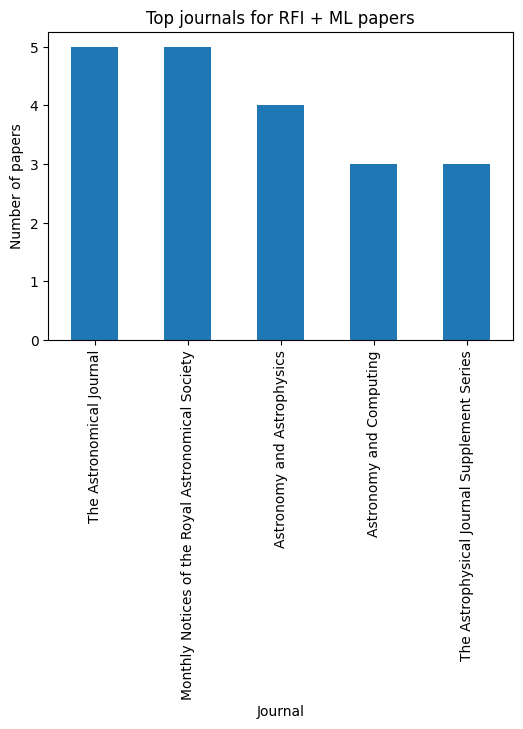

In [14]:
# Bar plot: top 5 journals
journal_counts = df['Journal'].value_counts().head(5)

plt.figure(figsize=(6,4))
journal_counts.plot(kind='bar')
plt.xlabel('Journal')
plt.ylabel('Number of papers')
plt.title('Top journals for RFI + ML papers')
plt.tight_layout()
plt.show()